## Median Subtraction

In [1]:
import numpy as np

In [2]:
a = np.array([[11, 12, 13, 2530, 11], [16, 18, 4800, 17, 18]])

In [3]:
m = np.median(a, axis=1, keepdims=True)

m

In [4]:
b = a - m

In [5]:
b

array([[-1.000e+00,  0.000e+00,  1.000e+00,  2.518e+03, -1.000e+00],
       [-2.000e+00,  0.000e+00,  4.782e+03, -1.000e+00,  0.000e+00]])

## Log Stretch

In [65]:
from math import log10, floor

def log_stretch_transform(black_point, saturation_range):
    
    log_saturation_range = log10(saturation_range)
    
    def fn(pixel_value):
        pixel_value -= black_point
        if pixel_value != pixel_value or pixel_value <= 1.0:
            return 0
        
        else:
            log_pixel_value = log10(pixel_value)
            if log_pixel_value >= log_saturation_range:
                return 255;
            else:
                return floor(256 * log_pixel_value / log_saturation_range)
        
    return fn

In [66]:
def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    trimmed_data = delete_last_columns(data, 4)
    img.data = trimmed_data
    return img

## SN 2022abik 2022-12-1415

### Observing Notes

Another round 30 60-second exposures each in g', r', and i', this time, proceeding across series rather than doing all of g' first.

TheSkyX crashed when approximately 80 of the planned 90 images had been taken.

### Calibration Photos

The calibration photos are in 2022-11-3001.

The bias photos should be discarded in favor of the 1-second and 30-second darks. It turns out TheSkyX ignores the exposure time
set on bias photos and does some very rapid exposure. I would not have noticed this if I had not needed some 30-second
bias files.

The 30-second darks are needed because the i' flats required 30 seconds to get a reasonable value.

In [85]:
import os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection, Combiner, combine, subtract_dark, flat_correct
import matplotlib.pyplot as plt
import astroalign as aa
%matplotlib inline

import twirl


A config file as been created in /Users/sacostamikulasek22/.twirl


### Initial Importing and Naming

In [68]:
# for an analyses of an observation run done with only a single filter,
# only the observation_date and the exposure times
# will need to be changed

observation_date = '2022-12-1415'
calibration_date = '2022-11-3001'
filters = ['g', 'r']
filter_full_names = ["Sloan g'", "Sloan r'"]
light_exposure = 60 * u.second
dark_exposure = light_exposure  # our method presumes this equality
flat_exposure = 1 * u.second
bias_exposure = flat_exposure  # our method presumes this equality

BINNING = 2  # 2x2 binning
SUBFRAMING = 2  # For "Half" Subframing
UNBINNED_PLATE_SCALE = 0.239
WIDTH_HEIGHT = (8288, 5644)
plate_scale = UNBINNED_PLATE_SCALE * BINNING * u.arcsec
# Our sensor is spec'd as 8288x5644, but when binned 2x2 and half-subframed, it writes out 4 columns of NaNs.
# Therefore, we treat it as if it had 16 fewer columns, e.g., we treat it as if it was 8272x5644. This bins
# and subframes to 2068 columns and 1411 rows, or about 0.275x0.187 degrees. Only the larger dimension is used.
fov = np.max((8272, 5644)) / BINNING / SUBFRAMING * plate_scale.to(u.deg).value
# Conveniences for referring to filters
SLOAN_G_FILTER = 0
SLOAN_R_FILTER = 1

In [69]:
dark_exposure = light_exposure  # our method presumes this equality
bias_exposure = flat_exposure  # our method presumes this equality

In [70]:
# directories where the observation and calibration photos being analyzed is kept

observation_directory = os.path.join(os.path.expanduser('~'), 'Transients', observation_date)
calibration_directory = os.path.join(os.path.expanduser('~'), 'Transients', calibration_date)

In [71]:
# subdirectories -- relative to observation and calibration directories

light_directories = [os.path.join(observation_directory, filter) for filter in filters]

# the 60-second darks
dark_directory = os.path.join(calibration_directory, 'dark')

# the 1-second g and r flats
flat_directories = [os.path.join(calibration_directory, 'flat', filter) for filter in filters]

# the 1-second darks/biases
bias_directory = os.path.join(calibration_directory, 'bias')

light_files_list = [ImageFileCollection(light_directory).files_filtered(include_path='True')
               for light_directory in light_directories]
dark_files = ImageFileCollection(dark_directory).files_filtered(include_path='True')
flat_files_list = [ImageFileCollection(flat_directory).files_filtered(include_path='True')
               for flat_directory in flat_directories]
bias_files = ImageFileCollection(bias_directory).files_filtered(include_path='True')

lights_list = [[trimmed_image_reader(file) for file in light_files] for light_files in light_files_list]
darks = [trimmed_image_reader(file) for file in dark_files]
flats_list = [[trimmed_image_reader(file) for file in flat_files] for flat_files in flat_files_list]
biases = [trimmed_image_reader(file) for file in bias_files]

# the aligned directories are written to not read from
aligned_directory_list = [os.path.join(light_directory, 'aligned') for light_directory in light_directories]

for aligned_directory in aligned_directory_list:
    if not os.path.exists(aligned_directory):
        os.makedirs(aligned_directory)

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


### The Calibration

In [72]:
method = 'median'  # the method can be changed to 'average'

# Combine darks, flats, and biases

method = 'median'  # the method can be changed to 'average'

master_dark = combine(darks, method=method)
master_flat_list = [combine(flats, method=method) for flats in flats_list]
master_bias = combine(biases, method=method)

lights_subtracted_list = [[subtract_dark(light,
                                   master_dark,
                                   data_exposure=light_exposure,
                                   dark_exposure=dark_exposure,
                                   scale=False)
                           for light in lights] for lights in lights_list]

# Perform dark subtraction

master_flat_subtracted_list = [subtract_dark(master_flat,
                                       master_bias,
                                       data_exposure=flat_exposure,
                                       dark_exposure=bias_exposure,
                                       scale=False)
                               for master_flat in master_flat_list]

# Perform flat division
               
lights_calibrated_list = [[flat_correct(l, master_flat_subtracted_list[i]) for l in lights_subtracted_list[i]]
                          for i in range(len(filters))]

In [73]:
### note the nested lists in the code above

In [74]:
# First grab some sample uncalibrated lights

sample_lights = [lights[0] for lights in lights_list]
sample_data_list = [np.asarray(sample_light) for sample_light in sample_lights]

# Median subtract

medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_data_list]
subtracted = [sample_data_list[i] - medians[i] for i in range(len(filters))]

# Then grab some sample calibrated lights

sample_calibrated_lights = [lights[0] for lights in lights_calibrated_list]
sample_calibrated_data_list = [np.asarray(sample_calibrated_light)
                               for sample_calibrated_light in sample_calibrated_lights]

# Median subtract

calibrated_medians = [np.median(sample, axis=1, keepdims=True) for sample in sample_calibrated_data_list]
calibrated_subtracted = [sample_calibrated_data_list[i] - calibrated_medians[i] for i in range(len(filters))]

In [75]:
# Log stretch uncalibrated

stretch_function = log_stretch_transform(7, 50)
transform = np.vectorize(stretch_function)
transformed_sample_lights = [transform(data) for data in subtracted]

# Log stretch calibrated (potentially with a different stretching function)

stretch_function2 = log_stretch_transform(7, 50)
transform2 = np.vectorize(stretch_function2)
transformed_sample_calibrated_lights = [transform2(data) for data in calibrated_subtracted]

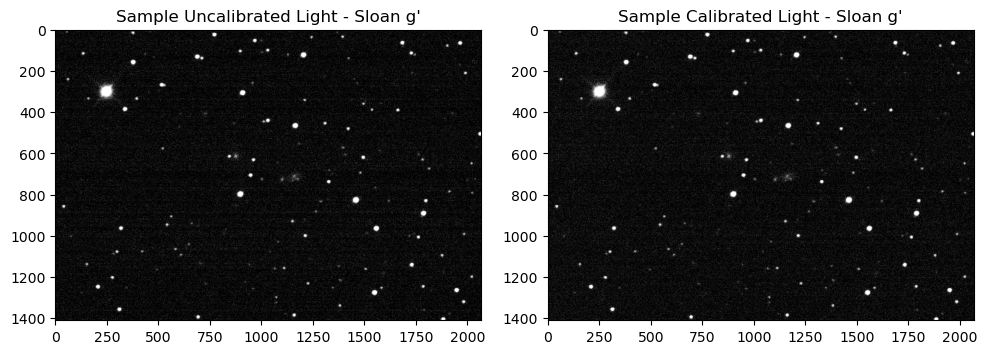

In [76]:
# Display first filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SLOAN_G_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SLOAN_G_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SLOAN_G_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

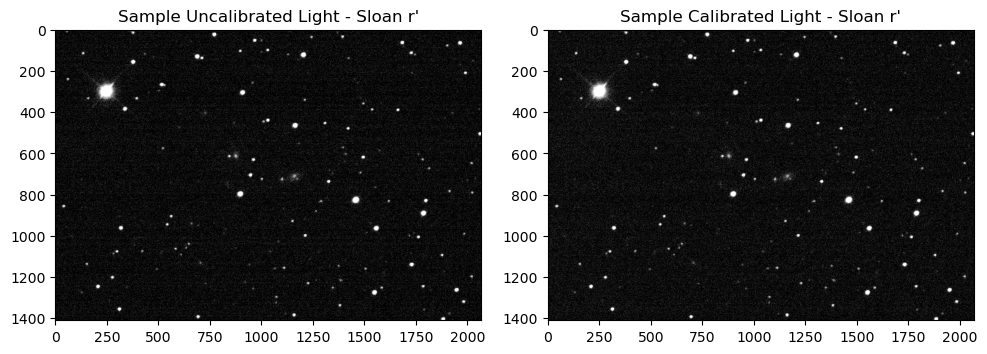

In [77]:
# Display second filter

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(transformed_sample_lights[SLOAN_R_FILTER], cmap='gray')
axes[0].set_title("Sample Uncalibrated Light - " + filter_full_names[SLOAN_R_FILTER])

axes[1].imshow(transformed_sample_calibrated_lights[SLOAN_R_FILTER], cmap='gray')
axes[1].set_title("Sample Calibrated Light - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

### Now Aligning lights

In [78]:
reference_light_list = [lights_calibrated[0] for lights_calibrated in lights_calibrated_list]

lights_aligned_with_footprints_list = [[aa.register(l, reference_light_list[i], detection_sigma=3.0) for
                                        l in lights_calibrated_list[i]] for i in range(len(filters))]

In [79]:
for i in range(len(filters)):
    # First we pick out all the stuff for a given filter
    lights = lights_list[i]
    light_files = light_files_list[i]
    lights_aligned_with_footprints = lights_aligned_with_footprints_list[i]
    aligned_directory = aligned_directory_list[i]
    for j in range(len(lights_aligned_with_footprints)):
        # Then we write all the files for that filter
        light_header = lights[j][0].header
        light_aligned_data = lights_aligned_with_footprints[j][0]
        aligned_file = os.path.join(aligned_directory, os.path.basename(light_files[j]))
        aligned_file2 = os.path.splitext(aligned_file)[0] + '_aligned.fit'
        fits.writeto(aligned_file2, light_aligned_data, light_header, overwrite=True)

### Read Back In and Stack the Lights

In [80]:
# we'll have to do this for each filter, so make some empty lists to append to
first_light_list = []  # this contains the whole first fits file for each filter
combined_light_list = []  # this contains the combined light data for each filter

for i in range(len(filters)):
    aligned_directory = aligned_directory_list[i]
    aligned_files = ImageFileCollection(aligned_directory).files_filtered(include_path='True')
    first_light_list.append(fits.open(aligned_files[0]))
    lights = [CCDData.read(file, unit=u.adu) for file in aligned_files]
    combined_light_list.append(combine(lights, method=method))

Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'. [astropy.wcs.wcs]
Set OBSGEO-Y to -4483197.997 from OBSGEO-[LBH].
Set OBSGEO-Z to  3851226.198 from OBSGEO-[LBH]'.


In [81]:
stacked_data_list = [np.asarray(combined_light) for combined_light in combined_light_list]

# Median subtract

medians_list = [np.median(stacked_data, axis=1, keepdims=True) for stacked_data in stacked_data_list]
stacked_subtracted_list = [stacked_data_list[i] - medians_list[i] for i in range(len(filters))]

# Log stretch

stretch_function3 = log_stretch_transform(0, 100)
transform3 = np.vectorize(stretch_function3)
transformed_stacked_subtracted_list = [[transform3(data) for data in stacked_subtracted]
                                       for stacked_subtracted in stacked_subtracted_list]

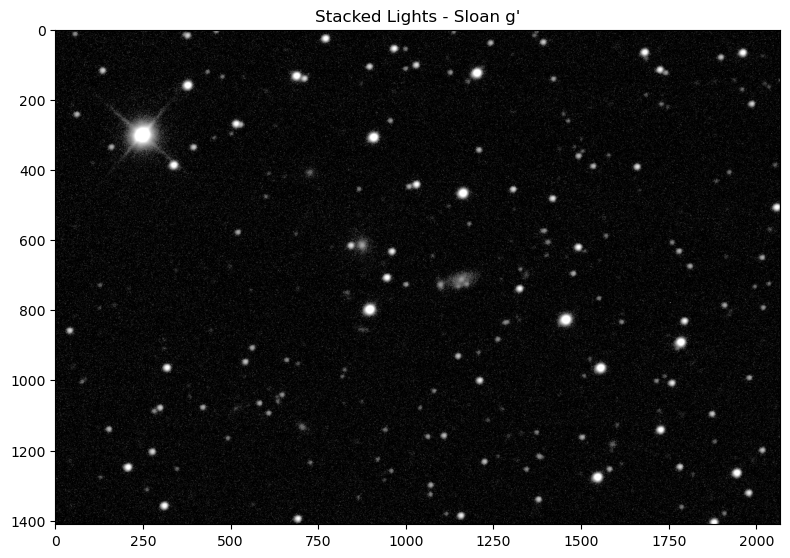

In [82]:
# Stacked Sloan g' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_G_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_G_FILTER])

plt.tight_layout()
plt.show()

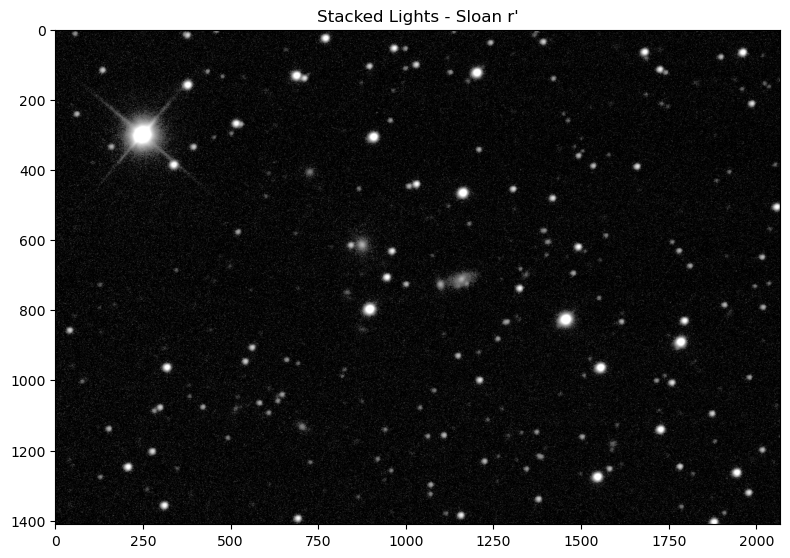

In [83]:
# Stacked Sloan r' Image

fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.imshow(transformed_stacked_subtracted_list[SLOAN_R_FILTER], cmap='gray')

axes.set_title("Stacked Lights - " + filter_full_names[SLOAN_R_FILTER])

plt.tight_layout()
plt.show()

In [101]:
header_list = [light[0].header for light in first_light_list]
center_list = [SkyCoord(header['OBJCTRA'], header['OBJCTDEC'], unit=(u.hourangle, u.deg)) for header in header_list]

center = center_list[SLOAN_G_FILTER]
data = stacked_data_list[SLOAN_G_FILTER]
stars = twirl.find_peaks(stacked_data_list[SLOAN_G_FILTER])[0:15]

plt.figure(figsize=(8,8))
med = np.median(data)
plt.imshow(stacked_data_list(0), cmap="Greys_r")
plt.plot(*stars.T, "o", fillstyle="none", c="w", ms=12)


NameError: name 'SLOAN_G_Filter' is not defined

<Figure size 800x800 with 0 Axes>

In [140]:
complete_transformed_g = transformed_stacked_subtracted_list[SLOAN_G_FILTER]

In [141]:
complete_transformed_g_array = np.asarray(new_thing)

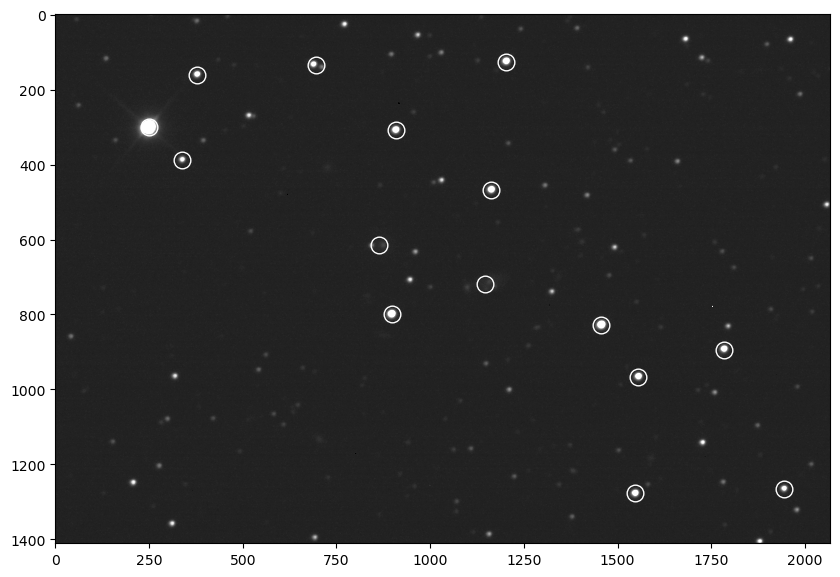

In [145]:
header_list = [light[0].header for light in first_light_list]
center_list = [SkyCoord(header['OBJCTRA'], header['OBJCTDEC'], unit=(u.hourangle, u.deg)) for header in header_list]

center = center_list[SLOAN_G_FILTER]
data = stacked_data_list[SLOAN_G_FILTER]
stars = twirl.find_peaks(complete_transformed_g_array)[0:15]

plt.figure(figsize=(10,10))
plt.imshow(stacked_data_list[0], cmap="Greys_r", vmax=np.std(data), vmin=-15)
plt.plot(*stars.T, "o", fillstyle="none", c="w", ms=12)

In [146]:
wcs = twirl.compute_wcs(stars, center, fov)

TypeError: 'Longitude' object with a scalar value does not support indexing

In [ ]:
### get remainder of plate solving done, try to get it written out

### the rest is my own desperate attempts

In [86]:
image = lights[0]

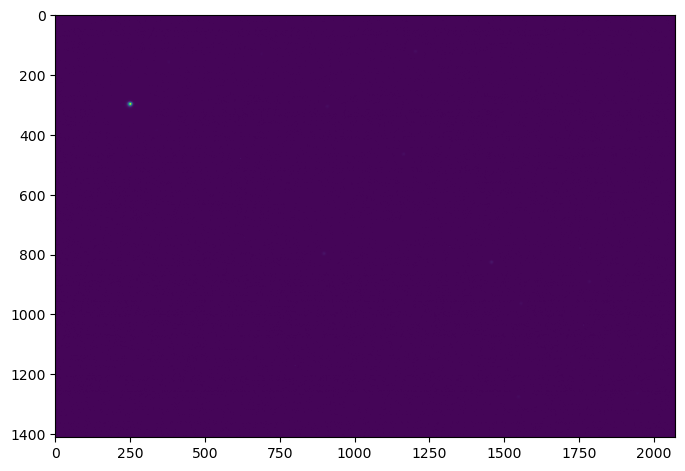

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.imshow(image, cmap='viridis')

plt.show(image)

In [89]:
print(transformed_stacked_subtracted_list[SLOAN_G_FILTER])

[0]


In [29]:
def delete_last_columns(arr, columns_to_delete):
    column_count = np.shape(arr)[1]
    del_arr = np.delete(arr, slice(column_count - columns_to_delete, column_count), 1)
    return del_arr

def trimmed_image_reader(file):
    img = CCDData.read(file, unit=u.adu)
    data = img.data
    trimmed_data = delete_last_columns(data, 4)
    img.data = trimmed_data
    return img

In [30]:
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import IRAFStarFinder
from photutils.psf import (DAOGroup, IntegratedGaussianPRF,
                           IterativelySubtractedPSFPhotometry)

In [90]:
sigma_psf = 100.0

### residual_image = photometry.get_residual_image()

NameError: name 'residual_image' is not defined

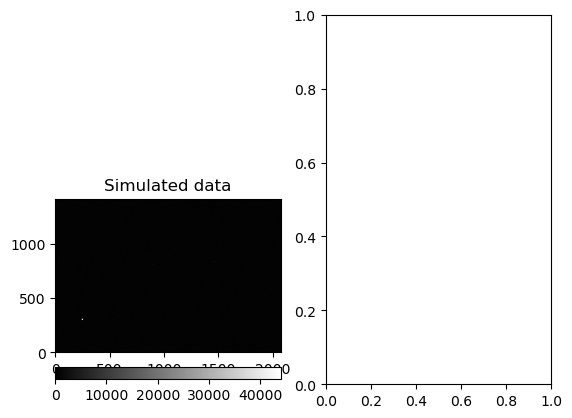

In [36]:
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', aspect=1, interpolation='nearest',
               origin= 'lower' )
plt.title('data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap='gray', aspect=1,
           interpolation='nearest', origin='lower')
plt.title('Residual Image')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)
plt.show()

In [102]:
header_list = [light[0].header for light in first_light_list]


In [103]:
first_light_list[0]

In [104]:
first_light_list[1]

In [105]:
first_light_list[0][0]

In [106]:
first_light_list[0][0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2068                                                  
NAXIS2  =                 1411                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
SBUUID  = '{54851c0b-c0eb-4329-9339-a29d053b6092}' / Photo UUID                 
EXPTIME =                  60. / SBIGFITSEXT Total exposure time in seconds     
SWCREATE= 'TheSky Version 10.5.0 Build 13225 (64 bit)' / SBIGFITSEXT Name & vers
COLORCCD=                    0 / Non zero if image is from a Bayer color ccd    
DISPINCR=                    1 / Non zero to automatically display the image in 
PICTTYPE=                   

In [107]:
first_light_list[0][0].header['FOCPOS']

6639.0

In [ ]:
## need to make changes to the headers